In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 생육 환경 최적화 경진대회


**주제**
- [Algorithm] 청경채 사진과 환경 데이터를 활용한 잎면적 예측 알고리즘 개발
- [Analytics] 적상추 데이터 활용 생육정도를 알 수 있는 정량 지표 발굴

In [ ]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import cv2
import random

## 메모리 용량 적은 데이터 만들기

https://dacon.io/competitions/official/235897/codeshare/4878

In [ ]:
main_path = "/content/drive/MyDrive/TNT/22-1 컴퓨터비전/dacon"
train_imgs = glob(main_path+"/train/*/*/*.png") + glob(main_path+"/train/*/*/*.jpg")
train_imgs = sorted(train_imgs)
test_imgs = glob(main_path+"/test/image/*.png") + glob(main_path+"/test/image/*.jpg")
test_imgs = sorted(test_imgs)
train_data = glob(main_path+"/train/*/meta/*.csv")
train_label = glob(main_path+"/train/*/*.csv")
test_data = glob(main_path+"/test/meta/*.csv")
preprocessing_train_imgs = "/content/drive/MyDrive/TNT/22-1 컴퓨터비전/dacon/pre_train"
preprocessing_test_imgs = "/content/drive/MyDrive/TNT/22-1 컴퓨터비전/dacon/pre_test"
if not os.path.exists(preprocessing_train_imgs):
    os.mkdir(preprocessing_train_imgs)
if not os.path.exists(preprocessing_test_imgs):
    os.mkdir(preprocessing_test_imgs)

### image data

#### plot image 

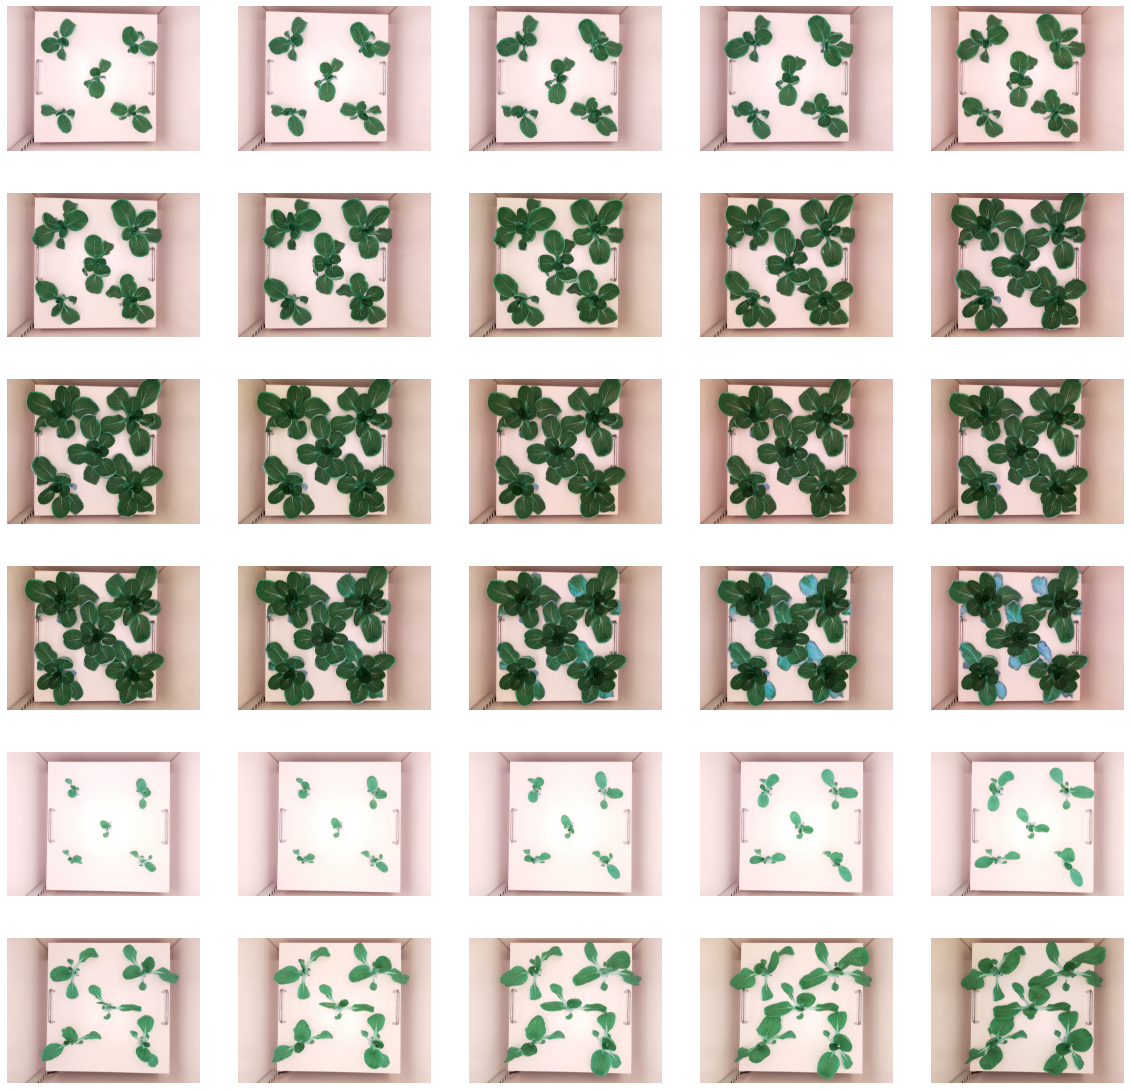

In [ ]:
plt.figure(figsize = (20,20))
for i in range(30):
  plt.subplot(6,5,i+1)
  img = cv2.imread(train_imgs[i])
  plt.imshow(img)
  plt.axis('off')

In [ ]:
plt.figure(figsize = (20,20))
for i in range(30):
  plt.subplot(6,5,i+1)
  j = random.randrange(1,460)
  img = cv2.imread(test_imgs[j])
  plt.imshow(img)
  plt.axis('off')

#### image segmentation

In [ ]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

In [ ]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
import torchvision.transforms as T
from torch import tensor
import torch
import numpy as np

def segmentation(image):
  img = image.copy()

  # Apply the transformations needed
  trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)

  # Pass the input through the net
  out = fcn(inp)['out']
  
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  #print(om.shape)
  #print(np.unique(om))

  rgb = decode_segmap(om)

  return rgb

In [ ]:
import pickle
from PIL import Image

leaf_train_data = {}
leaf_train_area = []
train_names = []
for i in tqdm(train_imgs):
    name = i.split("/")[-1]
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    pil_image = Image.fromarray(img)
    img = segmentation(pil_image)
    
    #img = np.array(img)
    #plt.imshow(img); plt.show()
    leaf_a = np.sum(img/255)  # 잎이 차지하는 픽셀 수
    leaf_train_area.append(leaf_a)
    train_names.append(name)

leaf_train_data['leaf_area'] = leaf_train_area
leaf_train_data['name'] = train_names

with open('/content/drive/MyDrive/TNT/22-1 컴퓨터비전/dacon/pre_train/leaf_train_data.pkl','wb') as f:
  pickle.dump(leaf_train_data,f)

100%|██████████| 1592/1592 [1:03:05<00:00,  2.38s/it]


#### save image data

In [ ]:
import pickle

leaf_train_data = {}
leaf_train_area = []
train_names = []
for i in tqdm(train_imgs):
    name = i.split("/")[-1]
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    img = image_segmentation(img)
    img = np.array(img)
    leaf_a = np.sum(img/255) # 잎이 차지하는 픽셀 수
    leaf_train_area.append(leaf_a)
    train_names.append(name)

leaf_train_data['leaf_area'] = leaf_train_area
leaf_train_data['name'] = train_names

with open('/content/drive/MyDrive/TNT/22-1 컴퓨터비전/dacon/pre_train/leaf_train_data.pkl','wb') as f:
  pickle.dump(leaf_train_data,f)

100%|██████████| 1592/1592 [35:16<00:00,  1.33s/it]


In [ ]:
leaf_test_data = {}
leaf_test_area = []
test_names = []
for i in tqdm(test_imgs):
    name = i.split("/")[-1]
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    img = image_segmentation(img)
    img = np.array(img)
    leaf_a = np.sum(img/255)
    leaf_test_area.append(leaf_a)
    test_names.append(name)

leaf_test_data['leaf_area'] = leaf_test_area
leaf_test_data['name'] = test_names

with open('/content/drive/MyDrive/TNT/22-1 컴퓨터비전/dacon/pre_test/leaf_test_data.pkl','wb') as f:
  pickle.dump(leaf_test_data,f)

100%|██████████| 460/460 [07:14<00:00,  1.06it/s]


In [ ]:
for i in tqdm(train_imgs):
    name = i.split("/")[-1]
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(preprocessing_train_imgs,name), img)

for i in tqdm(test_imgs):
    name = i.split("/")[-1]
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(preprocessing_test_imgs,name), img)

100%|██████████| 460/460 [02:03<00:00,  3.73it/s]
